# Analyze the dependencies in pypi metadata
I parsed the requirements out of every package on pypi using the PyPi_Metatdata and Parse_requirements notebook. The output is a csv file:

- requirements.csv: Contains the packages and their formal requirements

In [6]:
from __future__ import print_function, division

import pandas as pd
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
import matplotlib.pyplot as plt
from matplotlib import patches

import seaborn as sns
import operator
import numpy as np
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')

## Read in the requirements data.

The data is stored in a csv file (separated by the '\t' character).

In [7]:
requirements = pd.read_csv('requirements.csv')

In [37]:
def make_graph(df, min_edges=0):
    DG = nx.DiGraph()
    DG.add_nodes_from(df.package_name.unique())
    edges = df.loc[df.requirement.notnull(), ['package_name', 'requirement']].values
    DG.add_edges_from(edges)
    
    # Remove bad nodes
    DG.remove_nodes_from(['.', 'nan', np.nan])
    
    deg = dict(DG.degree())
    to_remove = [n for n in deg.keys() if deg[n] <= min_edges]
    DG.remove_nodes_from(to_remove)
    
    return DG

In [38]:
# Make a dotfile to import into gephi and make the network graph
DG = make_graph(requirements, min_edges=10)
write_dot(DG, 'requirements_graph.dot')

In [40]:
dep_graph = make_graph(requirements, min_edges=0)
len(dep_graph.nodes)

26211

# Statistic plots

## 1: Histogram of the number of connections for the top several packages

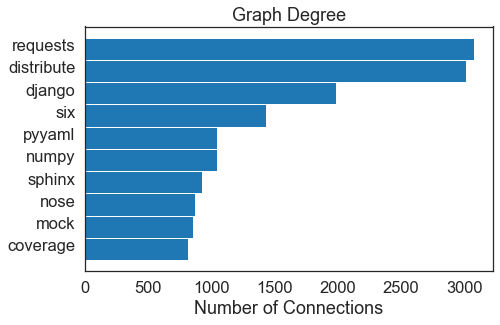

In [58]:
sorted_dict = sorted(dict(dep_graph.in_degree()).items(), key=operator.itemgetter(1))[::-1]

N = 10
x = np.arange(N)
y = np.array([d[1] for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.2)
_ = ax.set_yticklabels(xlabels)
ax.set_xlabel('Number of Connections')
ax.set_title('Graph Degree')
fig.subplots_adjust(left=0.27, bottom=0.1, top=0.95)

fig.savefig('Connections.png')

## PageRank

Similar to the node degree, but with some extra magic.

C:\Users\dangerchen\AppData\Local\Temp\ipykernel_24680\2236555258.py:1: DeprecationWarning: networkx.pagerank_scipy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  pr = nx.link_analysis.pagerank_scipy(dep_graph)


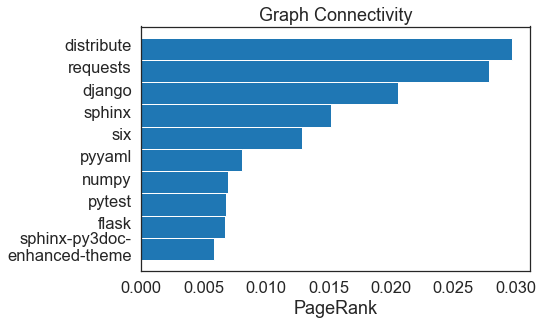

In [59]:
pr = nx.link_analysis.pagerank_scipy(dep_graph)
sorted_dict = sorted(pr.items(), key=operator.itemgetter(1))[::-1]

N = 10
x = np.arange(N)
y = np.array([d[1] for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
xlabels[0] = 'sphinx-py3doc-\nenhanced-theme'
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.2)
_ = ax.set_yticklabels(xlabels)
ax.set_xlabel('PageRank')
ax.set_title('Graph Connectivity')
fig.subplots_adjust(left=0.30, bottom=0.1, top=0.95)

fig.savefig('PageRank.png')

# Degree Distribution
A random graph has a ~gaussian distribution of degrees (the number of connections to each node). Social network-type graphs are more exponential/power law with most nodes having a few connections and a few having LOTS of connections. What does this one look like?

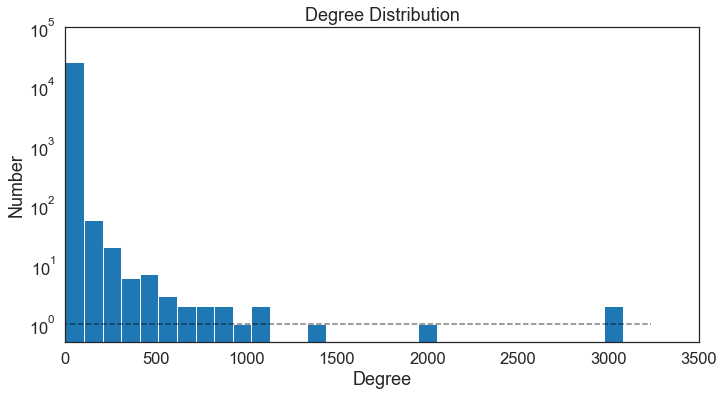

In [66]:
deg = dict(dep_graph.degree())

bins=30
fig, ax = plt.subplots(1, 1, figsize=(11,6))
ax.hist(deg.values(), bins=bins, density=False, stacked=True)
ax.plot(ax.get_xlim(), [1, 1], 'k--', alpha=0.5)
ax.set_xlabel('Degree')
ax.set_ylabel('Number')
ax.set_title('Degree Distribution')
ax.set_yscale('log')
ax.set_xlim(0,3500)
ax.set_ylim((0.5, 1e5))

fig.subplots_adjust(left=0.1, bottom=0.15)
fig.savefig('DegreeDistribution.png')

Yep, this has a really fast cutoff, with the vast majority of packages having very few connections. The black line shows where there is one package in the bin. It's basically a power-law, which arises in a "rich get richer" model. In other words, some packages (the ones with very high degree) are required by many things, so new packages also require them. They also tend to be older packages, which means they've had longer to accumulate packages that depend on them.

# Centrality Measures

The statistics above are basically degree centrality measures, but there are actual statistics that look at it too.

- **Betweenness Centrality** The betweenness centrality of node n is defined as the proportion of best paths between any other pairs of nodes which pass through n.

In [67]:
bc = nx.betweenness_centrality(dep_graph)

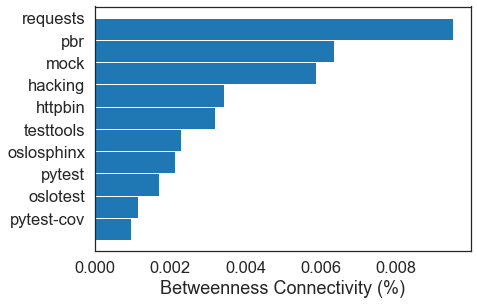

In [68]:
sorted_dict = sorted(bc.items(), key=operator.itemgetter(1))[::-1]

N = 10
x = np.arange(N)
y = np.array([d[1]*100 for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
fig, ax = plt.subplots(1, 1, figsize=(9, 4))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.5)
_ = ax.set_yticklabels(xlabels)
ax.set_xlabel('Betweenness Connectivity (%)')
fig.subplots_adjust(left=0.32, bottom=0.1, top=0.95)

fig.savefig('Betweenness.png')